Uses results from aperture photometry to derive the optical depth of the atmosphere for a given night of observing.
Does the following:
- Fits star flux as a function of airmass to find optical depth.
- Uses optical depth with each star cube to find an F_top for each star cube
- Takes the median of F_top
- Uses F_top to find beta (photometric conversion factor)

In [1]:
import numpy as np
from numpy import pi, r_
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy import optimize

### Functions

In [2]:
def F_obs(chi,tau,F_top):
    # Function to use with curve_fit() to get tau
    # F_top falls off with -tau*chi to give you F_obs
    return F_top*np.exp(-tau*chi)

def Ftop(chi,tau,F_obs):
    # returns the flux at the top of the atmosphere by correcting for the atm
    return F_obs*np.exp(tau*chi)

def flux1(mag1,mag2,flux2):
    # Useful for returning the flux of a star if it were scaled to Vega's magnitude.
    # flux1 = Star's flux as Vega
    # flux2 = Star's measured flux
    # mag1 = Vega's flux
    # mag2 = Star's flux
    return flux2*(10**(0.4*(mag2-mag1)))

def flux_relative_to_vega(mag2,flux2):
    # Same as flux1, but with Vega's magnitude hard-coded.
    # returns Star's flux as Vega
    # flux2 = Star's measured flux
    # mag2 = Star's flux
    mag1 = 0.03 # Vega's V magnitude
    return flux2*(10**(0.4*(mag2-mag1)))

In [33]:
def tau_flux_fit(science_directory,science_list,starlist_directory,star_directory):
    # science directory = location of Jupiter cube
    # science list = location+name of Jupiter image list
    # starlist_directory = location of image name lists for each cube. Assumes that name of star image lists are star1, star2, etc.
    # star_directory = location of all star fits files
    # Make sure standard stars don't have significant reddening and that V mag is approximately average.
    # Star lists need to be named in the format star1, star2, etc.
    
    
    # Quieries:
    num_stars = raw_input('How many individual stars were imaged? ')
    
    V_mags = []
    for i in range(0,int(num_stars)):
        mags = raw_input('For star '+str(i)+', what is it\'s V magnitude? ')
        V_mags.append(mags)
        
    num_cubes = int(raw_input('How many total cubes are there? '))
    
    airmass_plot_query = raw_input('Do you want to see a plot of airmasses for all of the star cubes? y/n ')
    snr_plot_query = raw_input('Do you want to see a plot of the SNR spectrum for each star cube? y/n ')
    flux_plot_query = raw_input('Do you want to see a plot of the stars\'s flux? y/n ')
        
    # Pull wavelengths to analyze from science cube
    '''print 'Pulling wavelength array from science images...'
    wl_sci = []
    sciencelist = np.loadtxt(science_list,dtype=str)
    for i in range(0,len(sciencelist)):
        im = fits.open(science_directory+sciencelist[i])
        if im[0].header['rfon'] == 1:
            wl_sci.append(im[0].header['lambda'])
        im.close()'''
                
    # load star lists into dictionaries
    star_list_dict = {}
    for i in range(0,num_cubes):
        star_list_dict['star'+str(i+1)+'_list'] = np.loadtxt(starlist_directory+'star'+str(i+1),dtype=str) # appends star lists in the wrong direction, but okay as long as we're consistent
    
    # Pull airmasses, wavelengths, star flux, and snr of each image from from each cube and assign them to a dictionary
    airmass_dict = {}; airmass_wl_dict = {}; star_snr_dict = {}; star_flux_dict = {}
    for i in range(0,len(star_list_dict)):
        airmass_list = []; airmass_wl_list = []; star_snr_list = []; star_flux_list = []
        for j in star_list_dict['star'+str(i+1)+'_list']:
            #print j # Each image in the list
            im = fits.open(star_directory+str(j))
            if im[0].header['rfon'] == 1:
                airmass_list.append(im[0].header['airmass'])
                airmass_wl_list.append(im[0].header['lambda'])
                star_snr_list.append(im[0].header['star_snr'])    
                star_flux_list.append(im[0].header['star_flx'])
            im.close()
        airmass_dict['airmass_star'+str(i+1)] = airmass_list
        airmass_wl_dict['airmass_wl_star'+str(i+1)] = airmass_wl_list
        star_snr_dict['snr_star'+str(i+1)] = star_snr_list
        star_flux_dict['flux_star'+str(i+1)] = star_flux_list
        
    # Plot airmass coverage
    if airmass_plot_query == 'y':
        for j in range(0,len(airmass_dict)):
            plt.plot(airmass_dict['airmass_star'+str(j+1)], airmass_wl_dict['airmass_wl_star'+str(j+1)],'.')
        plt.title('Airmass coverage')
        plt.ylabel('Wavelength')
        plt.xlabel('Airmass')
        plt.legend(airmass_dict.keys())
        plt.show()
        
    # Plot SNR spectra
    if snr_plot_query == 'y':
        for j in range(0,len(airmass_wl_dict)):
            plt.plot(airmass_wl_dict['airmass_wl_star'+str(j+1)], star_snr_dict['snr_star'+str(j+1)], '.')
        plt.title('SNR of All Cubes')
        plt.ylabel('SNR')
        plt.xlabel('Wavelength')
        plt.legend(star_snr_dict.keys())
        plt.show()
        
    # Plot flux spectra
    if flux_plot_query == 'y':
        for j in range(0,len(airmass_wl_dict)):
            plt.plot(airmass_wl_dict['airmass_wl_star'+str(j+1)], star_flux_dict['flux_star'+str(j+1)], '.')
        plt.title('Star Flux')
        plt.ylabel('Flux (counts/sec)')
        plt.xlabel('Wavelength')
        plt.legend(star_flux_dict.keys())
        plt.show()
        
        

How many individual stars were imaged? 1
For star 0, what is it's V magnitude? 2
How many total cubes are there? 2
Do you want to see a plot of airmasses for all of the star cubes? y/n y
Do you want to see a plot of the SNR spectrum for each star cube? y/n y
Do you want to see a plot of the stars's flux? y/n y


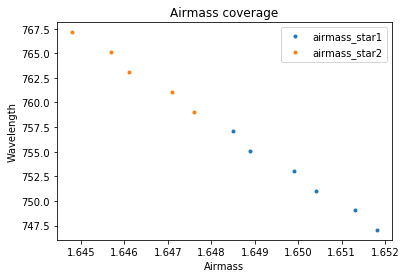

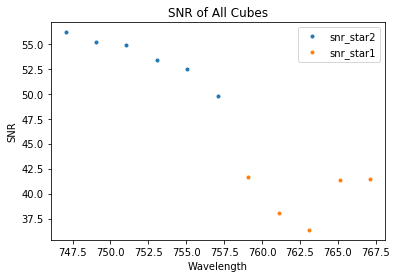

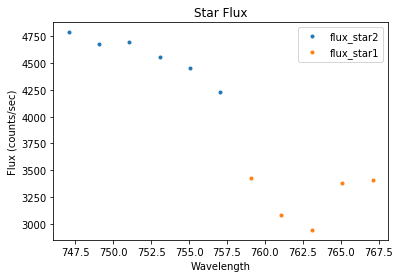

In [34]:
tau_flux_fit('/Volumes/external_hd/march2017/redo/jupiter/',\
            '/Volumes/external_hd/march2017/march_2017_sciimages',\
            '/Volumes/external_hd/calstar_test/',\
            '/Volumes/external_hd/calstar_test/')

In [15]:
d = {}
for i in range(3):
    d["group" + str(i)] = [i, i+1]

In [16]:
for i in d:
    for j in d[i]:
        print j # j is each element in the dictionary


1
2
0
1
2
3


In [17]:
a,b,c = d

In [18]:
d["group1"]
d[a]

[1, 2]

In [26]:
d.keys()

['group1', 'group0', 'group2']

In [30]:
d = {}; b = {}